# Metrics across sample numbers

In [1]:
# import pandas as pd
# from baseline.eval import cal_group_kl_divergence

# eval_list = []
# l1 = [i*10 for i in range(11)]
# l2 = [i*100 for i in range(2,11)]
# for num_samples in l1+l2:
#     result_file = f"models/mobility_agent/mobility_agent_{num_samples}.csv"
#     result_df = pd.read_csv(result_file)
#     kl_df, overall_kl,overall_mae = cal_group_kl_divergence(result_df=result_df)
#     for target in ["primary_mode","duration_minutes"]:
#         kld_score = kl_df[kl_df["target"] == target]['kl_divergence'].mean()
#         mea_score = kl_df[kl_df["target"] == target]['mae'].mean()
#         eval_list.append({
#             "model":"mobility_agent",
#             "num_samples":num_samples,
#             "target":target,
#             "kld_score": kld_score,
#             "mea_score":mea_score
#         })

# eval_df = pd.DataFrame(eval_list)
# eval_df.head(2)


In [2]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Set the style for the plots
# plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_context("notebook", font_scale=1.2)

# # Create subplots for each target
# fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# for i, target in enumerate(eval_df['target'].unique()):
#     target_df = eval_df[eval_df['target'] == target].sort_values('num_samples')
    
#     # Get the x values (sample numbers) and create positions for categorical plotting
#     x_values = target_df['num_samples'].tolist()
#     x_positions = np.arange(len(x_values))
    
#     # Create primary y-axis
#     ax1 = axes[i]
#     color = 'tab:blue'
#     ax1.set_xlabel('Number of Samples')
#     ax1.set_ylabel('KL Divergence', color=color)
#     ax1.plot(x_positions, target_df['kld_score'], marker='o', color=color, linewidth=2)
#     ax1.tick_params(axis='y', labelcolor=color)
    
#     # Set x-ticks to show all sample numbers evenly spaced
#     ax1.set_xticks(x_positions)
#     ax1.set_xticklabels(x_values, rotation=45, ha='right')
    
#     # Highlight transition from 10-increment to 100-increment with a vertical line
#     transition_idx = len(l1)-1  # Index where we transition from l1 to l2
#     if transition_idx < len(x_positions):
#         ax1.axvline(x=transition_idx-0.5, color='gray', linestyle='--', alpha=0.5)
    
#     # Create secondary y-axis
#     ax2 = ax1.twinx()
#     color = 'tab:red'
#     ax2.set_ylabel('Mean Absolute Error', color=color)
#     ax2.plot(x_positions, target_df['mea_score'], marker='s', color=color, linewidth=2)
#     ax2.tick_params(axis='y', labelcolor=color)
    
#     ax1.set_title(f'Metrics for {target}')
#     ax1.grid(True)
    
#     # Add legend
#     lines1, labels1 = ax1.get_legend_handles_labels()
#     lines2, labels2 = ax2.get_legend_handles_labels()
#     ax1.legend(lines1 + lines2, ['KL Divergence', 'Mean Absolute Error'], 
#                loc='upper right')
    
#     # Add text annotations for scale changes
#     # if transition_idx < len(x_positions):
#     #     ax1.text(transition_idx-1, ax1.get_ylim()[1]*0.95, 'Step: 10', 
#     #             ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
#     #     ax1.text(transition_idx+1, ax1.get_ylim()[1]*0.95, 'Step: 100', 
#     #             ha='left', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# plt.tight_layout()
# plt.suptitle('Performance Metrics Across Different Sample Sizes', y=1.02, fontsize=16)
# plt.subplots_adjust(top=0.9)
# plt.show()

# Mobility Agent vs ML models

In [65]:
import pandas as pd
from tqdm import tqdm
from baseline.train import train_baseline_model
from baseline.eval import cal_group_kl_divergence
import os

def get_mobility_agent_result(sample_list,result_folder= "models/mobility_agent",model_name="mobility_agent"):
    eval_list = []
    for num_samples in sample_list:
        result_file = os.path.join(result_folder,f"mobility_agent_{num_samples}.csv")
        result_df = pd.read_csv(result_file)
        primary_mode_list = ['walking', 'biking', 'auto_passenger', 'public_transit','private_auto', 'on_demand_auto','other_travel_mode']
        duration_minutes_list = ['0-10','10-20', '20-30', '30-40', '40-50', '50-60']
        # Filter the dataframe with valid output
        result_df = result_df[result_df['predicted_mode'].isin(primary_mode_list)]
        result_df = result_df[result_df['predicted_duration'].isin(duration_minutes_list)]
        kl_df, overall_kl, overall_mae = cal_group_kl_divergence(result_df=result_df)
        eval_list.append({
            "model": model_name,
            "num_samples": num_samples,
            "overall_kl": overall_kl,
            "overall_mae": overall_mae
        })
    return eval_list

# Initialize the list with mobility agent results
l1 = [i*10 for i in range(11)]
l2 = [i*100 for i in range(2,11)]
all_samples = l1 + l2

eval_list1 = get_mobility_agent_result(all_samples,result_folder= "models/mobility_agent",model_name="Preference Chain1")
eval_list2 = get_mobility_agent_result(all_samples,result_folder= "models/mobility_agent_gpt",model_name="Preference Chain2")

eval_list = eval_list1 + eval_list2

In [66]:
train_file = "data/reference/replica-cambridge_trips.csv"
eval_file = 'data/eval/replica-cambridge_trips_eval.csv'
model_keys = ["RF", "XGB", "MLP"]
sample_model_pairs = [(s, m, train_file, eval_file) for s in all_samples if s > 0 for m in model_keys]

from joblib import Parallel, delayed

# This will automatically handle nested parallelism cases
ml_results = Parallel(n_jobs=-1, backend="loky", verbose=0)(
    delayed(train_baseline_model)(*args) 
    for args in tqdm(sample_model_pairs, total=len(sample_model_pairs))
)

 49%|████▉     | 28/57 [00:04<00:05,  5.52it/s] 

========Optimizing parameters (model=XGBoost num_samples=10) ========
Best parameters: {'estimator__gamma': 0, 'estimator__learning_rate': 1e-05, 'estimator__max_depth': None, 'estimator__n_estimators': 50, 'estimator__subsample': 0.9}
Best score: 7.1436
=======Training model (model=XGBoost num_samples=10) =======
=======Evaluating model  (model=XGBoost num_samples=10) =======
Overall average KL divergence: 4.9860
Overall mean absolute error: 0.1249
========Optimizing parameters (model=XGBoost num_samples=20) ========
Best parameters: {'estimator__gamma': 0, 'estimator__learning_rate': 1e-05, 'estimator__max_depth': None, 'estimator__n_estimators': 100, 'estimator__subsample': 0.9}
Best score: 4.6977
=======Training model (model=XGBoost num_samples=20) =======
=======Evaluating model  (model=XGBoost num_samples=20) =======
Overall average KL divergence: 5.2555
Overall mean absolute error: 0.1373
========Optimizing parameters (model=XGBoost num_samples=30) ========
Best parameters: {'es

 74%|███████▎  | 42/57 [00:10<00:04,  3.33it/s]

========Optimizing parameters (model=XGBoost num_samples=70) ========
Best parameters: {'estimator__gamma': 0, 'estimator__learning_rate': 1e-05, 'estimator__max_depth': None, 'estimator__n_estimators': 10, 'estimator__subsample': 0.9}
Best score: 1.5107
=======Training model (model=XGBoost num_samples=70) =======
=======Evaluating model  (model=XGBoost num_samples=70) =======
Overall average KL divergence: 3.3757
Overall mean absolute error: 0.1072
========Optimizing parameters (model=RandomForest num_samples=70) ========
Best parameters: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50}
Best score: 0.1556
=======Training model (model=RandomForest num_samples=70) =======
=======Evaluating model  (model=RandomForest num_samples=70) =======
Overall average KL divergence: 2.9114
Overall mean absolute error: 0.1017
========Optimizing parameters (model=XGBoost num_samples=80) ========
Best parameters: {'estima

100%|██████████| 57/57 [00:20<00:00,  2.79it/s]

========Optimizing parameters (model=MultilayerPerceptron num_samples=70) ========
Best parameters: {'estimator__activation': 'tanh', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (128, 128)}
Best score: 0.0028
=======Training model (model=MultilayerPerceptron num_samples=70) =======
=======Evaluating model  (model=XGBoost num_samples=200) =======
Overall average KL divergence: 2.6505
Overall mean absolute error: 0.0976


=======Evaluating model  (model=MultilayerPerceptron num_samples=70) =======
Overall average KL divergence: 1.4509
Overall mean absolute error: 0.0703
========Optimizing parameters (model=RandomForest num_samples=400) ========
Best parameters: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50}
Best score: 0.0001
=======Training model (model=RandomForest num_samples=400) =======
=======Evaluating model  (model=RandomForest num_samples=400) =======
Overall average KL divergence: 1.3680
Overall mean absolute error: 0.0813
========Optimizing parameters (model=XGBoost num_samples=300) ========
Best parameters: {'estimator__gamma': 0, 'estimator__learning_rate': 0.001, 'estimator__max_depth': 10, 'estimator__n_estimators': 100, 'estimator__subsample': 0.9}
Best score: 0.3040
=======Training model (model=XGBoost num_samples=300) =======
=======Evaluating model  (model=XGBoost num_samples=300) =======
Overall avera

In [67]:
# Add non-None results to the list
result_list = eval_list + [r for r in ml_results if r is not None]
# Convert to DataFrame and save
result_df = pd.DataFrame(result_list)
result_df.to_csv("models/scores.csv", index=False)
print(f"Results saved to models/scores.csv")
result_df.head()

Results saved to models/scores.csv


,model,num_samples,overall_kl,overall_mae
0,Preference Chain1,0,1.249948,0.185377
1,Preference Chain1,10,0.709912,0.123127
2,Preference Chain1,20,0.670283,0.106373
3,Preference Chain1,30,0.569380,0.092031
4,Preference Chain1,40,0.596527,0.107043


Exception ignored in: <function ResourceTracker.__del__ at 0x103e48540>
Traceback (most recent call last):
  File "/Users/kai/.local/share/uv/python/cpython-3.13.3-macos-aarch64-none/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/kai/.local/share/uv/python/cpython-3.13.3-macos-aarch64-none/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/kai/.local/share/uv/python/cpython-3.13.3-macos-aarch64-none/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


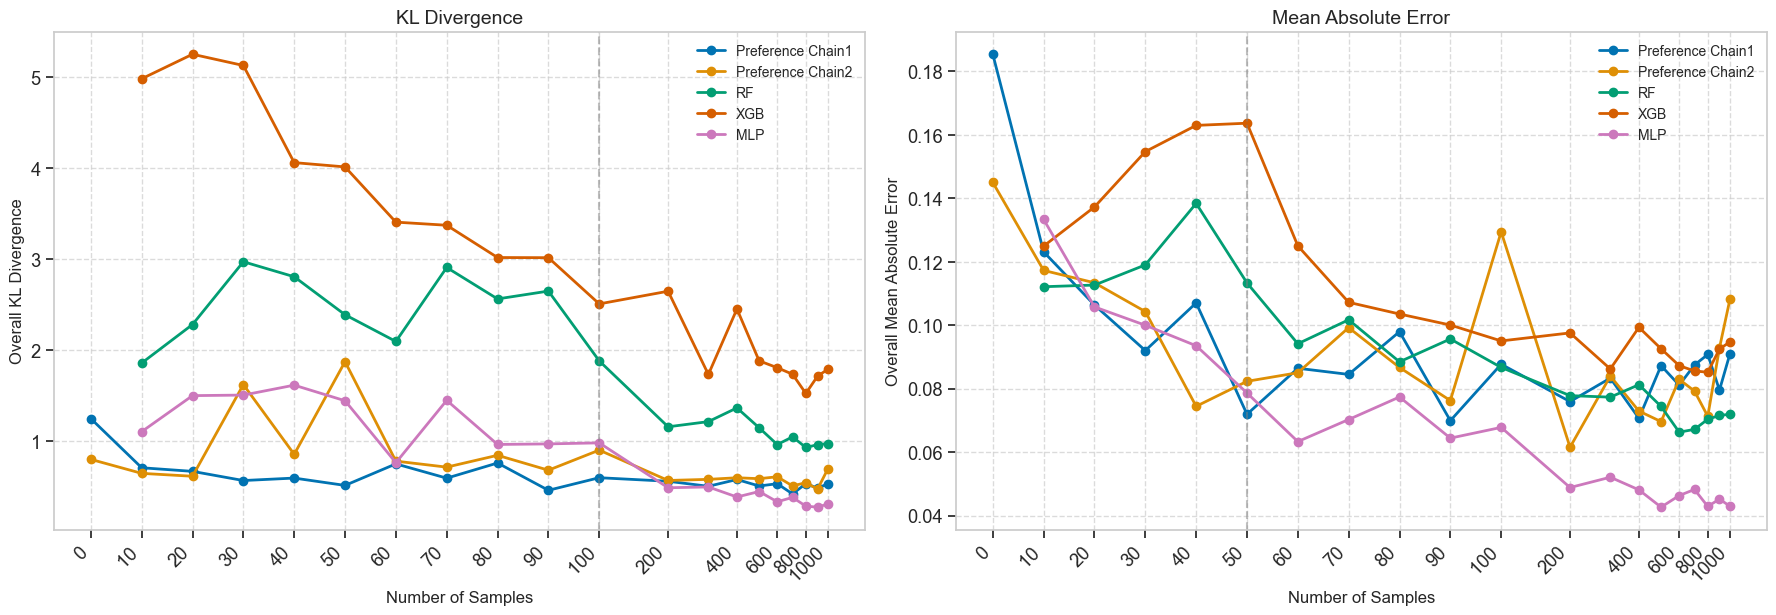

Exception ignored in: <function ResourceTracker.__del__ at 0x107f48540>
Traceback (most recent call last):
  File "/Users/kai/.local/share/uv/python/cpython-3.13.3-macos-aarch64-none/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/kai/.local/share/uv/python/cpython-3.13.3-macos-aarch64-none/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/kai/.local/share/uv/python/cpython-3.13.3-macos-aarch64-none/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x101bc8540>
Traceback (most recent call last):
  File "/Users/kai/.local/share/uv/python/cpython-3.13.3-macos-aarch64-none/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/kai/.local/share/uv/python/cpython-3.13.3-macos-aarch64-none/lib/python3.13/multiprocessing/resource_tracker.py", line 91,

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import pandas as pd

plot_df =pd.read_csv("models/scores.csv")
# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Get unique models and create a color palette
models = plot_df['model'].unique()
palette = sns.color_palette("colorblind", len(models))
model_color = dict(zip(models, palette))

# Get the x values we want to plot
sample_values = sorted(plot_df['num_samples'].unique())
tick_samples = [i*10 for i in range(11)] + [i*200 for i in range(1,6)]

# Plot KL divergence in the first subplot
ax = axes[0]
for model in models:
    # Filter data for this model
    model_df = plot_df[plot_df['model'] == model].sort_values('num_samples')
    ax.plot(model_df['num_samples'], model_df['overall_kl'], 
            marker='o', linewidth=2, 
            label=f"{model}", 
            color=model_color[model])

# Set up x-axis scale to give more space to 0-100 range
ax.set_xscale('symlog', linthresh=100, linscale=2)  # Linear scale until 100, then logarithmic
ax.set_xticks(tick_samples)
ax.set_xticklabels([str(x) for x in tick_samples], rotation=45, ha='right')

# Add vertical line at transition point
ax.axvline(x=100, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Overall KL Divergence', fontsize=12)
ax.set_title('KL Divergence', fontsize=14)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)

# Plot MAE in the second subplot
ax = axes[1]
for model in models:
    # Filter data for this model
    model_df = plot_df[plot_df['model'] == model].sort_values('num_samples')
    ax.plot(model_df['num_samples'], model_df['overall_mae'], 
            marker='o', linewidth=2, 
            label=f"{model}", 
            color=model_color[model])

# Set up x-axis scale to give more space to 0-100 range
ax.set_xscale('symlog', linthresh=100, linscale=2)  # Linear scale until 100, then logarithmic
ax.set_xticks(tick_samples)
ax.set_xticklabels([str(x) for x in tick_samples], rotation=45, ha='right')

# Add vertical line at transition point
ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Overall Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error', fontsize=14)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and add title
plt.tight_layout()
# plt.suptitle('Model Performance Across Different Sample Sizes (Lower is Better)', 
#             fontsize=16, y=1.02)
plt.subplots_adjust(top=0.85)

# Show the plot
plt.show()

In [7]:
# from baseline.train import train_baseline_model
# import random
# import numpy as np
# import os

# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed) 

# train_file = "data/reference/replica-cambridge_trips.csv"
# eval_file = 'data/eval/replica-cambridge_trips_eval.csv'

# for i in range(1,11):
#     num_samples = i*100
#     train_baseline_model(num_samples=num_samples,model_key="MLP",train_file=train_file,eval_file=eval_file)
    

KeyError: 'target'

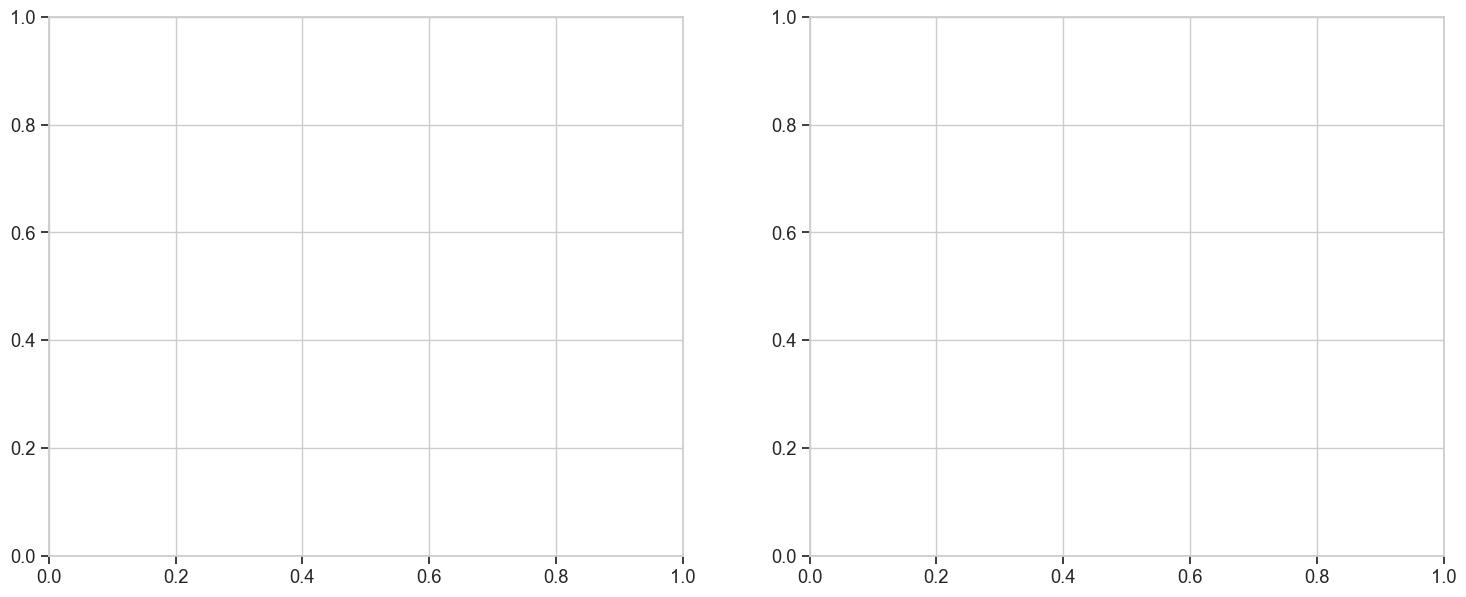

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Get unique models and ensure consistent ordering
model_order = ['mobility_agent', 'RF', 'XGB', 'MLP']  # Define explicit order
models = [m for m in model_order if m in eval_df['model'].unique()]  # Filter to existing models
targets = eval_df['target'].unique()

# Define colors for targets
target_colors = {'primary_mode': '#1f77b4', 'duration_minutes': '#ff7f0e'}

# Set width of bars and positions
bar_width = 0.35
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Data preparation - use model_order for consistent ordering
primary_data = []
duration_data = []
for model in models:
    primary_row = eval_df[(eval_df['model'] == model) & (eval_df['target'] == 'primary_mode')]
    duration_row = eval_df[(eval_df['model'] == model) & (eval_df['target'] == 'duration_minutes')]
    
    if not primary_row.empty:
        primary_data.append(primary_row.iloc[0])
    if not duration_row.empty:
        duration_data.append(duration_row.iloc[0])

primary_df = pd.DataFrame(primary_data)
duration_df = pd.DataFrame(duration_data)

# KLD subplot
ax = axes[0]
bars1 = ax.bar(r1, primary_df['kld_score'], width=bar_width, label='primary_mode', 
              color=target_colors['primary_mode'], alpha=0.8)
bars2 = ax.bar(r2, duration_df['kld_score'], width=bar_width, label='duration_minutes', 
              color=target_colors['duration_minutes'], alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
               f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Set labels and titles
ax.set_ylabel('KL Divergence', fontsize=12)
ax.set_title('KL Divergence by Model and Target', fontsize=14)
ax.set_xticks([r + bar_width/2 for r in range(len(models))])
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# MAE subplot
ax = axes[1]
bars1 = ax.bar(r1, primary_df['mea_score'], width=bar_width, label='primary_mode', 
              color=target_colors['primary_mode'], alpha=0.8)
bars2 = ax.bar(r2, duration_df['mea_score'], width=bar_width, label='duration_minutes', 
              color=target_colors['duration_minutes'], alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.003,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Set labels and titles
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Model and Target', fontsize=14)
ax.set_xticks([r + bar_width/2 for r in range(len(models))])
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.suptitle('Model Performance Comparison by Metric (Lower is Better)', 
            fontsize=16, y=1.02)
plt.subplots_adjust(top=0.85)
plt.show()